# Medulla population level decoders

Comparing ventral-medial to dorsal-lateral medulla in their choice predictions on the population level, and comparing them to the video predictions of those sessions.

Will need the per timepoint population level decoders for the two regions and also pull out the video predictions from the data somewhere.



In [173]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pickle

import local_env
import VideoAnalysisUtils.population_decoding_utils as pdu
import VideoAnalysisUtils.functions as func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The analysis will have to have the following steps:
- Data loading
- Identify neurons in each region (based on ccf and label)
- Outer cross validation for AUC (5 fold)
- PCA and logistic regression for the population level decoders (16 PCs)
- Internal 10-fold cross validation for logistic regression regularization param
- Predictions and AUC on test fold 



## Try single session population decoding

In [4]:
datafolder = '/media/kurgyis/TOSHIBA EXT/balint/Data/Map_ULTIMATE_preprocessed/stride3_bw40/'

sessions = os.listdir(datafolder)

sess = sessions[0]
session_files = [f for f in os.listdir(datafolder + sess) if f.endswith('.pickle')]
print(session_files)

['1_left_ALM.pickle', '2_right_Medulla.pickle', '3_left_Midbrain.pickle', '4_left_Orbital.pickle', '5_left_OtherCortex.pickle']


In [31]:
session_dict = pdu.load_session(datafolder + sess, 'Medulla')

In [61]:
regular_trials = pdu.get_regular_trial_mask(session_dict)
trial_type = session_dict['trial_type']

X_over_time = session_dict['fr'][:, regular_trials, :]
y = trial_type[regular_trials]

print(X_over_time.shape, y.shape)

(1765, 450, 87) (450,)


In [42]:
global_offset_vec = np.array([5700, 0, 5400])
coords = session_dict['ccf_coordinate'].copy() - global_offset_vec

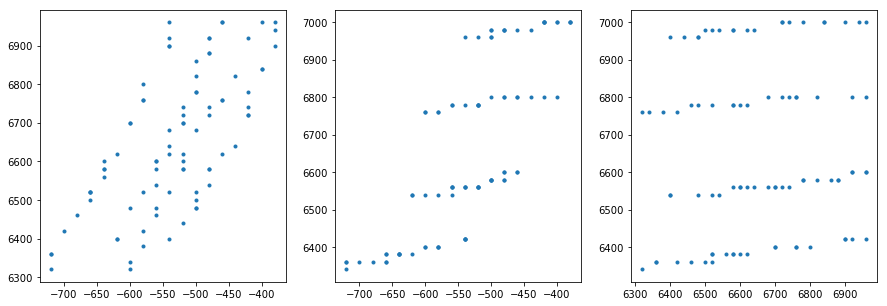

In [43]:
plt.subplots(1,3, figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(coords[:,0], coords[:,1], 'o', markersize = 3)

plt.subplot(1,3,2)
plt.plot(coords[:,0], coords[:,2], 'o', markersize = 3)

plt.subplot(1,3,3)
plt.plot(coords[:,1], coords[:,2], 'o', markersize = 3)


In [62]:
ventral_medial_mask = pdu.get_ventral_medial_mask(session_dict['ccf_coordinate'])
ventral_medial_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [67]:
X_vm = X_over_time[:, :, ventral_medial_mask]
X_dl = X_over_time[:, :, ~ventral_medial_mask]

In [85]:
auc_scores = pdu.nested_cross_validation(X_vm[1000,:,:25].reshape(1,-1,25), y)

print("Mean AUC scores across time points and folds:", auc_scores.mean(axis=1))
print("Mean AUC scores across folds:", auc_scores.mean())


Processing time point 1/1
Mean AUC scores across time points and folds: [0.90545765]
Mean AUC scores across folds: 0.9054576486465032


In [87]:
auc_scores = pdu.nested_cross_validation(X_dl, y)

Zero neurons.


## Check distribution of all Medulla neurons

In [46]:
allen_hierarchy_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'

df = pd.read_excel('../data/'+ allen_hierarchy_name,engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

r2_new = pickle.load(open('../data/final/r2_embed_cv_timeshift.pkl', 'rb'))
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
ccf_labels = r2_new['5_0']['ccf_labels'].copy()
alm_inds = np.where(r2_new['5_0']['is_alm'] == True)[0]
medulla_inds = func.get_single_area_inds('Medulla', df, ccf_labels,alm_inds)

all_ccf_coords = ccf_coords[medulla_inds] - global_offset_vec

In [58]:
ventral_medial_mask = (all_ccf_coords[:,1] >= 5200) * (np.abs(all_ccf_coords[:,0]) <= 1200)

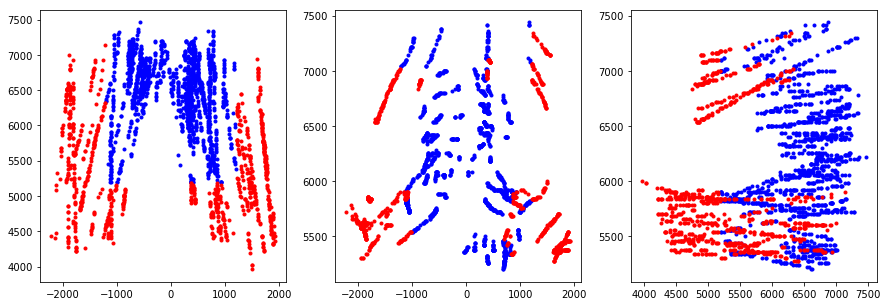

In [60]:
plt.subplots(1,3, figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(all_ccf_coords[ventral_medial_mask,0], all_ccf_coords[ventral_medial_mask,1], 'bo', markersize = 3)
plt.plot(all_ccf_coords[~ventral_medial_mask,0], all_ccf_coords[~ventral_medial_mask,1], 'ro', markersize = 3)

plt.subplot(1,3,2)
plt.plot(all_ccf_coords[ventral_medial_mask,0], all_ccf_coords[ventral_medial_mask,2], 'bo', markersize = 3)
plt.plot(all_ccf_coords[~ventral_medial_mask,0], all_ccf_coords[~ventral_medial_mask,2], 'ro', markersize = 3)

plt.subplot(1,3,3)
plt.plot(all_ccf_coords[ventral_medial_mask,1], all_ccf_coords[ventral_medial_mask,2], 'bo', markersize = 3)
plt.plot(all_ccf_coords[~ventral_medial_mask,1], all_ccf_coords[~ventral_medial_mask,2], 'ro', markersize = 3)

## Load and save video prediction auc

In [90]:
auc_data = pickle.load(open('../data/auc_analysis.pickle', 'rb'))
gh_info, sess_info, sess_info_marker, sub_gh_info = auc_data

In [95]:
sessions = list(sess_info.keys())
FRAME_LIST_LONG = [-882,-877,-872,-867,-862,-857,-852,-847,-842,-837,-832,-827,-822,-817,-812,-807,-802,-797,-792,-787,-782,-777,-772,-767,-762,-757,-752,-747,-742,-737,-732,-727,-722,-717,-712,-707,-702,-697,-692,-687,-682,-677,-672,-667,-662,-657,-652,-647,-642,-637,-632,-627,-622,-617,-612,-607,-602,-597,-592,-587,-582,-577,-572,-567,-562,-557,-552,-547,-542,-537,-532,-527,-522,-517,-512,-507,-502,-497,-492,-487,-482,-477,-472,-467,-462,-457,-452,-447,-442,-437,-432,-427,-422,-417,-412,-407,-402,-397,-392,-387,-382,-377,-372,-367,-362,-357,-352,-347,-342,-337,-332,-327,-322,-317,-312,-307,-302,-297,-292,-287,-282,-277,-272,-267,-262,-257,-252,-247,-242,-237,-232,-227,-222,-217,-212,-207,-202,-197,-192,-187,-182,-177,-172,-167,-162,-157,-152,-147,-142,-137,-132,-127,-122,-117,-112,-107,-102,-97,-92,-87,-82,-77,-72,-67,-62,-57,-52,-47,-42,-37,-32,-27,-22,-17,-12,-7,-2,3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78,83,88,93,98,103,108,113,118,123,128,133,138,143,148,153,158,163,168,173,178,183,188,193,198,203,208,213,218,223,228,233,238,243,248,253,258,263,268,273,278,283,288,293,298,303,308,313,318,323,328,333,338,343,348,353]

FRAME_LIST = FRAME_LIST_LONG[8:-8]

frame_array = np.array(FRAME_LIST)
time_list = (frame_array*0.0034)

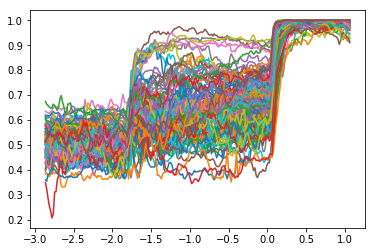

In [96]:
for sess in sessions:
    plt.plot(time_list,sess_info[sess]['lick']['auc']['test'])

In [98]:
save_dict = {sess: {'auc_video': sess_info[sess]['lick']['auc']['test'], 'times': time_list} for sess in sessions}

In [100]:
pickle.dump(save_dict, open('../data/video_behavior_auc.pickle', 'wb'))

## Load neural prediction aucs

In [188]:
datafolder = "/media/kurgyis/TOSHIBA EXT/balint/Data/Medulla_subregions_auc_lowres/"

session_files = os.listdir(datafolder)

neural_data = {}

for sess_file in session_files:
    sess = pickle.load(open(datafolder + sess_file, 'rb'))
    neural_data[sess['session']] = sess

In [189]:
video_data = pickle.load(open('../data/video_behavior_auc.pickle', 'rb'))

In [190]:
neural_data['SC030_20191002_32'].keys()

dict_keys(['auc_scores_vm', 'auc_scores_dl', 'tt', 'session', 'n_vm', 'n_dl'])

In [192]:
joint_data = {}

for sess in neural_data.keys():
    video_sess = sess.split('_')[0] + '_' + sess.split('_')[1][4:] + sess.split('_')[1][2:4] + '_' + sess.split('_')[2]
    if video_sess not in video_data.keys():
        video_sess = sess.split('_')[0] + '_' + sess.split('_')[1][4:] + sess.split('_')[1][2:4]
        if video_sess not in video_data.keys():
            print(sess, video_sess)
            continue
    joint_data[sess] = {
        'auc_vm': neural_data[sess]['auc_scores_vm'], 
        'auc_dl': neural_data[sess]['auc_scores_dl'], 
        'auc_video': video_data[video_sess]['auc_video'], 
        'video_tt': video_data[video_sess]['times'], 
        'neural_tt': neural_data[sess]['tt']}

SC030_20191002_32 SC030_100219
SC031_20191022_49 SC031_102219
SC033_20191112_31 SC033_111219
SC043_20200921_29 SC043_092120
SC066_20210413_6 SC066_041321
SC066_20210419_10 SC066_041921


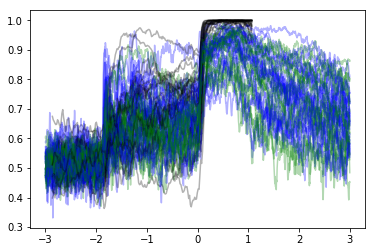

In [193]:
for sess,data in joint_data.items():
    if data['auc_vm'] is not None: plt.plot(data['neural_tt'], data['auc_vm'].mean(axis = 1), 'b-', alpha = 0.3)
    if data['auc_dl'] is not None: plt.plot(data['neural_tt'], data['auc_dl'].mean(axis = 1), 'g-', alpha = 0.3)
    plt.plot(data['video_tt'], data['auc_video'], 'k-', alpha = 0.3)

In [195]:
pickle.dump(joint_data, open('../data/medulla_subregions_joint_data.pickle', 'wb'))

## Plot the decoding performances

In [196]:
video_tt = list(joint_data.values())[0]['video_tt']
neural_tt = list(joint_data.values())[0]['neural_tt']

neural_data_inds = np.array([np.argmin(np.abs(neural_tt-t)) for t in video_tt])

vm_sessions = np.zeros(len(joint_data))
dl_sessions = np.zeros(len(joint_data))

auc_video = np.zeros((len(joint_data), len(video_tt)))
auc_vm = np.zeros((len(joint_data), len(video_tt)))
auc_dl = np.zeros((len(joint_data), len(video_tt)))

for i, (sess, data) in enumerate(joint_data.items()):
    if data['auc_vm'] is not None: 
        auc_vm[i] = data['auc_vm'].mean(axis = 1)[neural_data_inds]
        vm_sessions[i] = 1
    if data['auc_dl'] is not None: 
        auc_dl[i] = data['auc_dl'].mean(axis = 1)[neural_data_inds]
        dl_sessions[i] = 1
    auc_video[i] = data['auc_video']


In [197]:
def medulla_plotting(ax, mode = 'auc'):
    plt.xlabel('Time (s)')
    plt.xlim(-3,1.2)
    plt.xticks([-1.85,-1.2,0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if mode == 'auc': 
        plt.ylabel('Pred. AUC')
        plt.ylim(0.4,1.1)
        plt.hlines([0.5,1],-3,1.2, linestyles='--', color = 'grey')
        plt.vlines([-1.85,-1.2,0],0.4,1.1, linestyles='-', color = 'grey')
        plt.yticks([0.5,1])
    elif mode == 'diff': 
        plt.ylabel('AUC Diff')
        plt.ylim(-0.25, 0.25)
        plt.hlines([0,0.2],-3,1.2, linestyles='--', color = 'grey')
        plt.vlines([-1.85,-1.2,0],-0.25,0.25, linestyles='-', color = 'grey')
        plt.yticks([-0.20,0,0.2])

    

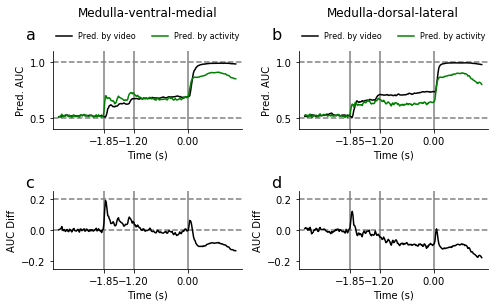

In [198]:
fig, _ = plt.subplots(2,2, figsize = (7.8,4), )
fig.subplots_adjust(hspace = 0.8, wspace = 0.3)

ax = plt.subplot(2,2,1)
medulla_plotting(ax)
ax.text(1.2*plt.xlim()[0], 1.1*plt.ylim()[1], 'a', fontsize = 16)
plt.title('Medulla-ventral-medial', pad = 35)
plt.plot(video_tt, auc_video[vm_sessions == 1].mean(axis = 0), 'k-')
plt.plot(video_tt, auc_vm[vm_sessions == 1].mean(axis = 0), 'g-')
plt.legend(['Pred. by video', 'Pred. by activity'], loc=(0., 1.1),  ncol=2, fontsize = 8, frameon = False)

ax = plt.subplot(2,2,2)
medulla_plotting(ax)
ax.text(1.2*plt.xlim()[0], 1.1*plt.ylim()[1], 'b', fontsize = 16)
plt.title('Medulla-dorsal-lateral', pad = 35)
plt.plot(video_tt, auc_video[dl_sessions == 1].mean(axis = 0), 'k-')
plt.plot(video_tt, auc_dl[dl_sessions == 1].mean(axis = 0), 'g-')
plt.legend(['Pred. by video', 'Pred. by activity'], loc=(0., 1.1),  ncol=2, fontsize = 8, frameon = False)

ax = plt.subplot(2,2,3)
medulla_plotting(ax,'diff')
ax.text(1.2*plt.xlim()[0], 1.1*plt.ylim()[1], 'c', fontsize = 16)
plt.plot(video_tt, auc_vm[vm_sessions == 1].mean(axis = 0) - auc_video[vm_sessions == 1].mean(axis = 0), 'k-')

ax = plt.subplot(2,2,4)
medulla_plotting(ax,'diff')
ax.text(1.2*plt.xlim()[0], 1.1*plt.ylim()[1], 'd', fontsize = 16)
plt.plot(video_tt, auc_dl[dl_sessions == 1].mean(axis = 0) - auc_video[dl_sessions == 1].mean(axis = 0), 'k-')

plt.savefig('../figs/supplementary_figs/S6.png', dpi = 300, bbox_inches = 'tight')

## Statistical comparison of the two subregions

In [199]:
sample_mask = (video_tt >= -2.3) * (video_tt < - 1.)

vm_inds = np.where(vm_sessions == 1)[0]

vm_cross_corrs = []
peak_times = []

for i, ind in enumerate(vm_inds):
    video_sample_auc = auc_video[ind][sample_mask == 1]
    vm_sample_auc = auc_vm[ind][sample_mask == 1]

    cross_corr = np.correlate(video_sample_auc - video_sample_auc.mean(),vm_sample_auc - vm_sample_auc.mean(), mode = 'full')
    vm_cross_corrs.append(cross_corr)

    peak_index = np.argmax(cross_corr)
    peak_offset = peak_index - len(video_sample_auc) + 1
    peak_times.append(peak_offset*17)

dl_inds = np.where(dl_sessions == 1)[0]

dl_cross_corrs = []
peak_times_dl = []

for i, ind in enumerate(dl_inds):
    video_sample_auc = auc_video[ind][sample_mask == 1]
    dl_sample_auc = auc_dl[ind][sample_mask == 1]

    cross_corr = np.correlate(video_sample_auc - video_sample_auc.mean(), dl_sample_auc - dl_sample_auc.mean(), mode = 'full')
    dl_cross_corrs.append(cross_corr)

    peak_index = np.argmax(cross_corr)
    peak_offset = peak_index - len(video_sample_auc) + 1
    peak_times_dl.append(peak_offset*17)

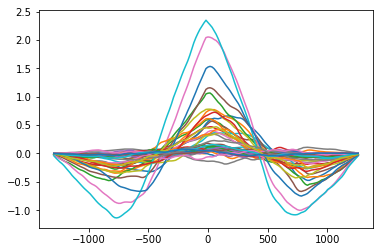

In [200]:
offsets = 17* np.arange(-sum(sample_mask),sum(sample_mask)-1)
plt.plot(offsets,np.array(vm_cross_corrs).T)
plt.plot(offsets,np.array(dl_cross_corrs).T)

In [215]:
t_statistic, p_value = stats.ttest_1samp(peak_times, 0)
print('Sample, ventral-medial')
print('%.2f+/-%.2f ms, p=%.4f, n=%d'%(np.mean(peak_times), np.std(peak_times)/np.sqrt(len(peak_times)), p_value, len(peak_times)))

Sample, ventral-medial
114.75+/-48.08 ms, p=0.0285, n=24


In [214]:
t_statistic, p_value = stats.ttest_1samp(peak_times_dl, 0)
print('Sample, dorsal-lateral')
print('%.2f+/-%.2f ms, p=%.4f, n=%d'%(np.mean(peak_times_dl), np.std(peak_times_dl)/np.sqrt(len(peak_times_dl)), p_value,len(peak_times_dl)))

Sample, dorsal-lateral
88.00+/-44.10 ms, p=0.0707, n=17


In [211]:
late_sample = (video_tt >= -1.55) * (video_tt < - 1.2)

auc_diff_vm = auc_vm[vm_sessions == 1][:,late_sample].mean(axis = 1) - auc_video[vm_sessions == 1][:,late_sample].mean(axis = 1)
auc_diff_dl = auc_dl[dl_sessions == 1][:,late_sample].mean(axis = 1) - auc_video[dl_sessions == 1][:,late_sample].mean(axis = 1)

t_statistic, p_value = stats.ttest_1samp(auc_diff_vm, 0)
print('Late sample, ventral-medial, AUC diff')
print('%.4f+/-%.4f, p=%.4f, n=%d'%(np.mean(auc_diff_vm), np.std(auc_diff_vm)/np.sqrt(len(auc_diff_vm)), p_value, len(auc_diff_vm)))

t_statistic, p_value = stats.ttest_1samp(auc_diff_dl, 0)
print('Late sample, dorsal-lateral, AUC diff')
print('%.4f+/-%.4f, p=%.4f, n=%d'%(np.mean(auc_diff_dl), np.std(auc_diff_dl)/np.sqrt(len(auc_diff_dl)), p_value, len(auc_diff_dl)))

Late sample, ventral-medial, AUC diff
0.0513+/-0.0241, p=0.0486, n=24
Late sample, dorsal-lateral, AUC diff
-0.0220+/-0.0199, p=0.2992, n=17


In [204]:
response_mask = (video_tt >= -0.3) * (video_tt <  1.2)

vm_response_cc = []
dl_response_cc = []
vm_response_cc_p = []
dl_response_cc_p = []

for i, ind in enumerate(vm_inds):
    video_response_auc = auc_video[ind][response_mask == 1]
    vm_response_auc = auc_vm[ind][response_mask == 1]

    cross_corr = np.correlate(video_response_auc - video_response_auc.mean(),vm_response_auc - vm_response_auc.mean(), mode = 'full')
    vm_response_cc.append(cross_corr)

    peak_index = np.argmax(cross_corr)
    peak_offset = peak_index - len(video_sample_auc) + 1
    vm_response_cc_p.append(peak_offset*17)

for i, ind in enumerate(dl_inds):
    video_response_auc = auc_video[ind][response_mask == 1]
    dl_response_auc = auc_dl[ind][response_mask == 1]

    cross_corr = np.correlate(video_response_auc - video_response_auc.mean(),dl_response_auc - dl_response_auc.mean(), mode = 'full')
    dl_response_cc.append(cross_corr)

    peak_index = np.argmax(cross_corr)
    peak_offset = peak_index - len(video_sample_auc) + 1
    dl_response_cc_p.append(peak_offset*17)

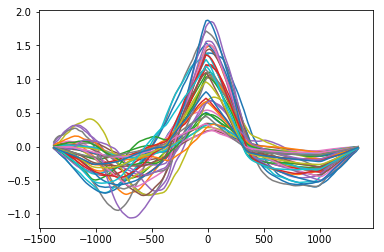

In [205]:
offsets = 17* np.arange(-sum(response_mask),sum(response_mask)-1)
plt.plot(offsets,np.array(vm_response_cc).T)
plt.plot(offsets,np.array(dl_response_cc).T)

In [209]:
t,p = stats.ttest_1samp(vm_response_cc_p, 0)
print('response, ventral-medial')
print('%.2f+/-%.2f ms, p=%.4f, n=%d'%(np.mean(vm_response_cc_p), np.std(vm_response_cc_p)/np.sqrt(len(vm_response_cc_p)), p, len(vm_response_cc_p)))

t,p = stats.ttest_1samp(dl_response_cc_p, 0)
print('response, dorsal-lateral')
print('%.2f+/-%.2f ms, p=%.4f, n=%d'%(np.mean(dl_response_cc_p), np.std(dl_response_cc_p)/np.sqrt(len(dl_response_cc_p)), p, len(dl_response_cc_p)))


response, ventral-medial
104.83+/-4.21 ms, p=0.0000, n=24
response, dorsal-lateral
105.00+/-6.20 ms, p=0.0000, n=17


In [207]:
t,p = stats.ttest_ind(vm_response_cc_p, dl_response_cc_p, equal_var = False)
print(p)

0.9828887095795653
